<a href="https://www.kaggle.com/code/jovanchua/threads-naive-tf-torch?scriptVersionId=138681841" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/threads-an-instagram-app-reviews/threads_reviews.csv


# Import libraries and datasets

## Import essential libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import warnings
import shutil
import datetime as dt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import datasets

In [3]:
PATH = "/kaggle/input/threads-an-instagram-app-reviews/"

dataset = pd.read_csv(PATH + "threads_reviews.csv", parse_dates = ['review_date'])

# EDA

In [4]:
display(dataset.head())
dataset.shape

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


(32910, 4)

In [5]:
vc_1 = dataset['rating'].value_counts().reset_index()

vc_1.columns = ['Rating', 'Count']  # Naming the columns

fig = px.bar(vc_1, x='Rating', y='Count', color='Rating', title='Ratings Distribution (1 to 5)')

fig.update_xaxes(title_text='Rating')  # Set x-label
fig.update_yaxes(title_text='Count')   # Set y-label

fig.show()

**Insights**:

There are substantially more 5* ratings than the rest.

In [6]:
vc_2 = dataset['source'].value_counts().reset_index()

vc_2.columns = ['Source', 'Count']  # Naming the columns

fig = px.pie(vc_2, names='Source', values='Count') 

fig.show()

**Insights**:

There are more reviews coming from the Google Play store than the Apple App store.

In [7]:
dataset['date'] = dataset['review_date'].dt.date
#dataset['year'] = dataset['review_date'].dt.year
#dataset['month'] = dataset['review_date'].dt.month
dataset['day'] = dataset['review_date'].dt.day
dataset['dayofweek'] = dataset['review_date'].dt.dayofweek + 1
dataset['weekend'] = dataset['review_date'].dt.weekday >= 5

In [8]:
aggregated_data = dataset.groupby('date')['rating'].mean().reset_index()
aggregated_data
fig = px.line(aggregated_data, x='date', y='rating')

fig.show()

**Insights**:

Hahaha, the ratings is definitely on a downward trend ever since its release, this seems to be useful as predictor and you can opt to play with it, but maybe it is out of scope for this notebook.

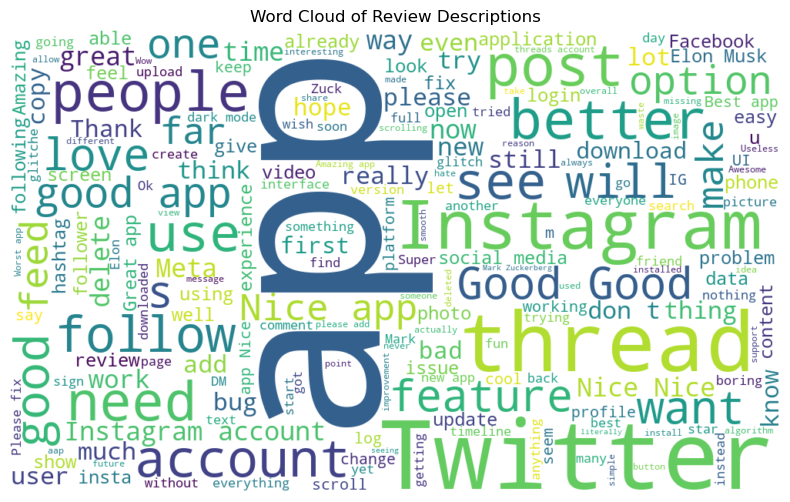

In [9]:
from wordcloud import WordCloud

text = ' '.join(dataset['review_description'])
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Descriptions')
plt.show()

**Insights**:

Of course Threads would be compared with Twitter, interesting to see 'Good' and 'Nice' which correlates with the amount of 5* ratings.

# Working with review_text

In [10]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

In [11]:
def clean_text(text):
    text = text.lower() # change to lowercase
    text = text.encode('utf-8', 'ignore').decode() # remove emojis, non-english characters and special characters
    text = re.sub('[' + string.punctuation + ']', '', text) # remove punctuations
    stop = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop]
    
    return ' '.join(filtered_text) if filtered_text else text


dataset['cleaned_reviews'] = dataset['review_description'].apply(lambda x: clean_text(x))

For visualisation purpose.

In [12]:
# Before
dataset['review_description'][0]

"Meh. Not the greatest experience on a Chromebook. Seems to be customized for phones only. Opens in a little screen that you can't expand or resize - for reasons that are a complete mystery to me. Judging from the fact that every other app I know of is resizeable, this seems like it was a conscious choice by the developers . Why you'd do something like this is beyond understanding and suggests a control freak approach. Not a great way to make a first impression."

In [13]:
# After
dataset['cleaned_reviews'][0]

'meh greatest experience chromebook seems customized phones opens little screen cant expand resize reasons complete mystery judging fact every app know resizeable seems like conscious choice developers youd something like beyond understanding suggests control freak approach great way make first impression'

In [14]:
def metafeatures(df):
    df['len_of_chars'] = df['cleaned_reviews'].apply(lambda x: len(x))
    
    df['len_of_words'] = df['cleaned_reviews'].apply(lambda x: len(word_tokenize(x)))
    
    df['avg_word_length'] = df['cleaned_reviews'].apply(lambda x: np.mean([len(w) for w in x.split()]))
    
    return df

dataset = metafeatures(dataset)
dataset.head()

,source,review_description,rating,review_date,date,day,dayofweek,weekend,cleaned_reviews,len_of_chars,len_of_words,avg_word_length
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24,2023-07-08,8,6,True,meh greatest experience chromebook seems custo...,305,41,6.463415
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48,2023-07-19,19,3,False,pretty good first launch easy use selfexplanat...,347,48,6.250000
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11,2023-07-06,6,4,False,brand new app well optimized however missing q...,328,50,5.580000
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25,2023-07-10,10,1,False,great app lot potential however lot needs fixe...,309,48,5.458333
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43,2023-07-06,6,4,False,app good needs lot functionality example searc...,281,42,5.714286


In [15]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('punkt')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
dataset['cleaned_reviews_tokenized'] = dataset['cleaned_reviews'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/

In [16]:
dataset['lemmatized'] = dataset['cleaned_reviews_tokenized'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
dataset['stemmed'] = dataset['cleaned_reviews_tokenized'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))

Let's try to make it into a function!

In [17]:
def preprocess_text(df):
    df['cleaned_reviews'] = df['review_description'].apply(lambda x: clean_text(x))
    df = metafeatures(df)
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    df['cleaned_reviews_tokenized'] = df['cleaned_reviews'].apply(lambda x: word_tokenize(x))
    df['lemmatized'] = df['cleaned_reviews_tokenized'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
    df['stemmed'] = df['cleaned_reviews_tokenized'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
    return df

In [18]:
%%time

df = preprocess_text(dataset)

CPU times: user 32.6 s, sys: 729 ms, total: 33.3 s
Wall time: 33.4 s


In [19]:
df.dropna(inplace = True)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [21]:
def prepare_data(df, type_ = 'lemmatized', vec = CountVectorizer()):
    X = df[type_]
    y = df['rating']
    
    X_post = vec.fit_transform(X)
    X_tr, X_val, y_tr, y_val = train_test_split(X_post, y, test_size = 0.2, shuffle = True, random_state = 42)
    
    return X_tr, X_val, y_tr, y_val    

# Naive approach

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score

In [23]:
def naive_predict(df, res, clf = MultinomialNB()):
    for clf in [LogisticRegression(multi_class='multinomial'), MultinomialNB()]:
        for type_ in ['lemmatized', 'stemmed']:
            for vec in [CountVectorizer(ngram_range = (1,3)), TfidfVectorizer(ngram_range = (1,3))]:
                X_tr, X_val, y_tr, y_val = prepare_data(df, type_ = type_, vec = vec)
                clf.fit(X_tr, y_tr)
                y_preds = clf.predict(X_val)
                y_pred_prob = clf.predict_proba(X_val)
                acc = accuracy_score(y_val, y_preds)
                precision = precision_score(y_val, y_preds, average = 'weighted')
                recall = precision_score(y_val, y_preds, average = 'weighted')
                f1 = f1_score(y_val, y_preds, average = 'weighted')
                rocauc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
                res[f'{clf}_{type_}_{vec}'] = {'accuracy': acc,
                                        'precision': precision,
                                        'recall': recall,
                                        'f1': f1,
                                        'rocauc': rocauc}
    return res

In [24]:
results = {}
results = naive_predict(df, results)

In [25]:
pd.DataFrame(results).T.sort_values(by = ['accuracy'], ascending = False)

,accuracy,precision,recall,f1,rocauc
"LogisticRegression(multi_class='multinomial')_stemmed_CountVectorizer(ngram_range=(1, 3))",0.693967,0.635791,0.635791,0.652833,0.779708
"LogisticRegression(multi_class='multinomial')_lemmatized_CountVectorizer(ngram_range=(1, 3))",0.693664,0.633629,0.633629,0.651489,0.780203
"LogisticRegression(multi_class='multinomial')_lemmatized_TfidfVectorizer(ngram_range=(1, 3))",0.691080,0.600676,0.600676,0.623080,0.805856
"MultinomialNB()_lemmatized_CountVectorizer(ngram_range=(1, 3))",0.690776,0.617714,0.617714,0.641931,0.704273
"MultinomialNB()_stemmed_CountVectorizer(ngram_range=(1, 3))",0.688801,0.613164,0.613164,0.639009,0.698481
"LogisticRegression(multi_class='multinomial')_stemmed_TfidfVectorizer(ngram_range=(1, 3))",0.688345,0.649677,0.649677,0.622461,0.806929
"MultinomialNB()_lemmatized_TfidfVectorizer(ngram_range=(1, 3))",0.685002,0.537941,0.537941,0.598940,0.753060
"MultinomialNB()_stemmed_TfidfVectorizer(ngram_range=(1, 3))",0.683939,0.536818,0.536818,0.598006,0.751326


# Combining text and meta features

In [26]:
X_tr, X_val, y_tr, y_val = train_test_split(df, df['rating'], test_size = 0.2, shuffle = True, random_state = 42)

## LogReg with meta feats

In [27]:
from sklearn.preprocessing import MinMaxScaler

META_FEATS_NUM = ['len_of_chars', 'len_of_words', 'avg_word_length']
META_FEATS_CAT = ['day', 'dayofweek', 'weekend']

text_feats = Pipeline([
    ('vec', CountVectorizer(ngram_range = (1,3)))
])

meta_feats_cat = Pipeline([
    ('ohe', OneHotEncoder())
])

meta_feats_num = Pipeline([
    ('scale', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('text', text_feats, 'lemmatized'),
        ('meta_cat', meta_feats_cat, META_FEATS_CAT),
        ('meta_num', meta_feats_num, META_FEATS_NUM)
    ]
)

model = Pipeline(
    [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial'))
    ]
)

model.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vec',
                                                                   CountVectorizer(ngram_range=(1,
                                                                                                3)))]),
                                                  'lemmatized'),
                                                 ('meta_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['day', 'dayofweek',
                                                   'weekend']),
                                                 ('meta_num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['len_of_chars',
                                                   'len_of_words',
                                                   'avg_word_length'])])),
                ('classifier', LogisticRegression(multi_class='multinomial'))])

In [28]:
y_preds = model.predict(X_val)
y_pred_probs = model.predict_proba(X_val)
acc = accuracy_score(y_val, y_preds)
precision = precision_score(y_val, y_preds, average = 'weighted')
recall = precision_score(y_val, y_preds, average = 'weighted')
f1 = f1_score(y_val, y_preds, average = 'weighted')
rocauc = roc_auc_score(y_val, y_pred_probs, multi_class = 'ovr')
results['combined_naive_log_reg'] = {'accuracy': acc,
                            'precision': precision,
                            'recall': recall,
                            'f1': f1,
                            'rocauc': rocauc}

## MultinomialNB with meta features

In [29]:
from sklearn.preprocessing import MinMaxScaler

META_FEATS_NUM = ['len_of_chars', 'len_of_words', 'avg_word_length']
META_FEATS_CAT = ['day', 'dayofweek', 'weekend']

text_feats = Pipeline([
    ('vec', CountVectorizer(ngram_range = (1,3)))
])

meta_feats_cat = Pipeline([
    ('ohe', OneHotEncoder())
])

meta_feats_num = Pipeline([
    ('scale', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('text', text_feats, 'lemmatized'),
        ('meta_cat', meta_feats_cat, META_FEATS_CAT),
        ('meta_num', meta_feats_num, META_FEATS_NUM)
    ]
)

model = Pipeline(
    [
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
    ]
)

model.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vec',
                                                                   CountVectorizer(ngram_range=(1,
                                                                                                3)))]),
                                                  'lemmatized'),
                                                 ('meta_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['day', 'dayofweek',
                                                   'weekend']),
                                                 ('meta_num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['len_of_chars',
                                                   'len_of_words',
                                                   'avg_word_length'])])),
                ('classifier', MultinomialNB())])

In [30]:
y_preds = model.predict(X_val)
y_pred_probs = model.predict_proba(X_val)
acc = accuracy_score(y_val, y_preds)
precision = precision_score(y_val, y_preds, average = 'weighted')
recall = precision_score(y_val, y_preds, average = 'weighted')
f1 = f1_score(y_val, y_preds, average = 'weighted')
rocauc = roc_auc_score(y_val, y_pred_probs, multi_class = 'ovr')
results['combined_naive_multinomialNB'] = {'accuracy': acc,
                            'precision': precision,
                            'recall': recall,
                            'f1': f1,
                            'rocauc': rocauc}

In [31]:
pd.DataFrame(results).T

,accuracy,precision,recall,f1,rocauc
"LogisticRegression(multi_class='multinomial')_lemmatized_CountVectorizer(ngram_range=(1, 3))",0.693664,0.633629,0.633629,0.651489,0.780203
"LogisticRegression(multi_class='multinomial')_lemmatized_TfidfVectorizer(ngram_range=(1, 3))",0.691080,0.600676,0.600676,0.623080,0.805856
"LogisticRegression(multi_class='multinomial')_stemmed_CountVectorizer(ngram_range=(1, 3))",0.693967,0.635791,0.635791,0.652833,0.779708
"LogisticRegression(multi_class='multinomial')_stemmed_TfidfVectorizer(ngram_range=(1, 3))",0.688345,0.649677,0.649677,0.622461,0.806929
"MultinomialNB()_lemmatized_CountVectorizer(ngram_range=(1, 3))",0.690776,0.617714,0.617714,0.641931,0.704273
"MultinomialNB()_lemmatized_TfidfVectorizer(ngram_range=(1, 3))",0.685002,0.537941,0.537941,0.598940,0.753060
"MultinomialNB()_stemmed_CountVectorizer(ngram_range=(1, 3))",0.688801,0.613164,0.613164,0.639009,0.698481
"MultinomialNB()_stemmed_TfidfVectorizer(ngram_range=(1, 3))",0.683939,0.536818,0.536818,0.598006,0.751326
combined_naive_log_reg,0.697766,0.640864,0.640864,0.656352,0.782620
combined_naive_multinomialNB,0.689257,0.596291,0.596291,0.613418,0.698617


# Neural Networks

In [32]:
X_tr, X_val = X_tr['lemmatized'], X_val['lemmatized']
y_tr, y_val = y_tr - 1, y_val - 1

## TensorFlow

In [33]:
import tensorflow as tf
from tensorflow.keras import layers

### Setting up tokenizer, vectorizer and embeddings

In [34]:
texts = X_tr
sent_lens = [len(sentence.split()) for sentence in texts]
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

26

In [35]:
vocab = set(word for document in texts for word in document)
len(vocab)

1510

In [36]:
max_tokens = 1600

In [37]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens = max_tokens,
                              output_sequence_length = output_seq_len)
vectorizer.adapt(texts)

In [38]:
import random
target_sentence = random.choice(texts)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{vectorizer([target_sentence])}")

Text:
good

Length of text: 1

Vectorized text:
[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [39]:
text_vocab = vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(text_vocab)}"), 
print(f"Most common words in the vocabulary: {text_vocab[:5]}")
print(f"Least common words in the vocabulary: {text_vocab[-5:]}")

Number of words in vocabulary: 1600
Most common words in the vocabulary: ['', '[UNK]', 'app', 'twitter', 'good']
Least common words in the vocabulary: ['minimal', 'market', 'learning', 'lastly', 'lang']


In [40]:
vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 1600,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 26,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 1600}

In [41]:
token_embed = layers.Embedding(input_dim = len(text_vocab),
                              output_dim = 128,
                              mask_zero = True,
                              name = 'token_embedding')

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
good

Sentence after vectorization (before embedding):
[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Sentence after embedding:
[[[ 0.00687116 -0.01832063 -0.02551643 ...  0.03356803  0.01945449
    0.04759843]
  [ 0.0207837  -0.02770966  0.04900936 ...  0.03895512 -0.02691874
    0.02770035]
  [ 0.0207837  -0.02770966  0.04900936 ...  0.03895512 -0.02691874
    0.02770035]
  ...
  [ 0.0207837  -0.02770966  0.04900936 ...  0.03895512 -0.02691874
    0.02770035]
  [ 0.0207837  -0.02770966  0.04900936 ...  0.03895512 -0.02691874
    0.02770035]
  [ 0.0207837  -0.02770966  0.04900936 ...  0.03895512 -0.02691874
    0.02770035]]]

Embedded sentence shape: (1, 26, 128)


### Dataloaders

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [43]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [44]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings)
x = layers.Dropout(0.2)(x)
x = x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

In [45]:
model_history = model.fit(train_dataset,
                         epochs=3,
                         validation_data=val_dataset
                         )

Epoch 1/3
823/823 [==============================] - 45s 37ms/step - loss: 1.0259 - accuracy: 0.6367 - val_loss: 0.8949 - val_accuracy: 0.6908
Epoch 2/3
823/823 [==============================] - 5s 6ms/step - loss: 0.8892 - accuracy: 0.6929 - val_loss: 0.9012 - val_accuracy: 0.6914
Epoch 3/3
823/823 [==============================] - 5s 6ms/step - loss: 0.8420 - accuracy: 0.7122 - val_loss: 0.9206 - val_accuracy: 0.6918


In [46]:
model.evaluate(val_dataset)

206/206 [==============================] - 1s 3ms/step - loss: 0.9206 - accuracy: 0.6918


[0.9206401705741882, 0.6918401718139648]

In [47]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) 
x = layers.Dense(128, activation="relu")(pretrained_embedding)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation="softmax")(x) 
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
model_2.fit(train_dataset,
            epochs=3,
            validation_data=val_dataset
           )

Epoch 1/3
823/823 [==============================] - 18s 15ms/step - loss: 0.9855 - accuracy: 0.6552 - val_loss: 0.8940 - val_accuracy: 0.6899
Epoch 2/3
823/823 [==============================] - 12s 15ms/step - loss: 0.9206 - accuracy: 0.6806 - val_loss: 0.8874 - val_accuracy: 0.6924
Epoch 3/3
823/823 [==============================] - 13s 16ms/step - loss: 0.8960 - accuracy: 0.6898 - val_loss: 0.8841 - val_accuracy: 0.6926


In [50]:
model_2.evaluate(val_dataset)

206/206 [==============================] - 2s 11ms/step - loss: 0.8841 - accuracy: 0.6926


[0.8840710520744324, 0.692599892616272]

In [51]:
inputs = layers.Input(shape=[], dtype=tf.string) 
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.LSTM(128, activation="relu", return_sequences=True)(tf.expand_dims(pretrained_embedding, 1)) 
x = layers.Dropout(0.2)(x)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_lstm.compile(loss="sparse_categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])


In [52]:
model_lstm.fit(train_dataset,
            epochs=3,
            validation_data=val_dataset
           )

Epoch 1/3
823/823 [==============================] - 25s 25ms/step - loss: 1.0145 - accuracy: 0.6431 - val_loss: 0.9018 - val_accuracy: 0.6874
Epoch 2/3
823/823 [==============================] - 20s 24ms/step - loss: 0.9341 - accuracy: 0.6736 - val_loss: 0.8918 - val_accuracy: 0.6903
Epoch 3/3
823/823 [==============================] - 20s 24ms/step - loss: 0.9193 - accuracy: 0.6790 - val_loss: 0.8876 - val_accuracy: 0.6911


In [53]:
model_lstm.evaluate(val_dataset)

206/206 [==============================] - 3s 12ms/step - loss: 0.8876 - accuracy: 0.6911


[0.8876476287841797, 0.6910803914070129]

In [54]:
from keras.regularizers import l1
from keras.layers import Bidirectional, BatchNormalization

l1_reg = 0.001

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)

# Using a bidirectional LSTM with L1 regularization
x = layers.Bidirectional(layers.LSTM(256, activation="relu", return_sequences=True, kernel_regularizer=l1(l1_reg)))(tf.expand_dims(pretrained_embedding, 1))
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)  # Add batch normalization layer

x = layers.Bidirectional(layers.LSTM(128, activation="relu", kernel_regularizer=l1(l1_reg)))(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x) 

outputs = layers.Dense(5, activation="softmax")(x)
model_bidirectional = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_bidirectional.compile(loss="sparse_categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])


In [55]:
model_bidirectional.fit(train_dataset,
            epochs=3,
            validation_data=val_dataset
           )

Epoch 1/3
823/823 [==============================] - 37s 35ms/step - loss: 5.3759 - accuracy: 0.6433 - val_loss: 1.2839 - val_accuracy: 0.6727
Epoch 2/3
823/823 [==============================] - 29s 36ms/step - loss: 1.2959 - accuracy: 0.6572 - val_loss: 1.2238 - val_accuracy: 0.6773
Epoch 3/3
823/823 [==============================] - 27s 32ms/step - loss: 1.2765 - accuracy: 0.6594 - val_loss: 1.2059 - val_accuracy: 0.6823


In [56]:
model_bidirectional.evaluate(val_dataset)

206/206 [==============================] - 3s 12ms/step - loss: 1.2059 - accuracy: 0.6823


[1.2059236764907837, 0.6822671294212341]

# Pytorch (HuggingFace) WIP

In [57]:
import torch
import torch.nn as nn

In [58]:
X = dataset['review_description']
y = dataset['rating'] - 1

In [59]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [60]:
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler

from torch.optim import Adam

In [61]:
from nltk.tokenize import word_tokenize

max_length = round(np.percentile([len(word_tokenize(sentence)) for sentence in X], 95))

In [62]:
from transformers import DistilBertTokenizer, DistilBertModel
from torch.nn.utils.rnn import pad_sequence

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# apply the tokenizer to your text data
X_tokenized = [tokenizer.encode(sent, add_special_tokens=True, max_length = 30, truncation = True, padding = 'max_length') for sent in X]

In [63]:
attention_masks = []
for seq in X_tokenized:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [64]:
X_tr, X_val, y_tr, y_val = train_test_split(X_tokenized, y, test_size = 0.2, random_state = 42)

In [65]:
X_train = torch.tensor(X_tr)
X_val = torch.tensor(X_val)
y_train = torch.tensor(y_tr.reset_index(drop = True), dtype=torch.long)
y_val = torch.tensor(y_val.reset_index(drop = True), dtype=torch.long)

In [66]:
train_data = TensorDataset(X_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

validation_data = TensorDataset(X_val, y_val)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

In [67]:
# Convert attention masks to Tensors
attention_masks = torch.tensor(attention_masks)

# Split masks into training and validation sets
masks_tr, masks_val, _, _ = train_test_split(attention_masks, y, test_size = 0.2, random_state = 42)

# Create TensorDatasets for masks
train_masks = TensorDataset(masks_tr)
val_masks = TensorDataset(masks_val)

# Create DataLoaders for masks
train_mask_dataloader = DataLoader(train_masks, sampler=train_sampler, batch_size=32)
val_mask_dataloader = DataLoader(val_masks, sampler=validation_sampler, batch_size=32)

In [68]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 768),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(768, 5)
        )

    def forward(self, input_ids, attention_mask):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        out = hidden_state[:, 0]
        out = self.classifier(out)
        return out

model = DistilBERTClass()
model.to(device);

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:21                                                                                   │
│                                                                                                  │
│   18 │   │   return out                                                                          │
│   19                                                                                             │
│   20 model = DistilBERTClass()                                                                   │
│ ❱ 21 model.to(device);                                                                           │
│   22                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1145 in to                    │
│                                                                                                  │
│   1142 │   │   │   │   │   │   │   non_blocking, memory_format=convert_to_format)                │
│   1143 │   │   │   return t.to(device, dtype if t.is_floating_point() or t.is_complex() else No  │
│   1144 │   │                                                                                     │
│ ❱ 1145 │   │   return self._apply(convert)                                                       │
│   1146 │                                                                                         │
│   1147 │   def register_full_backward_pre_hook(                                                  │
│   1148 │   │   self,                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:797 in _apply                 │
│                                                                                                  │
│    794 │                                                                                         │
│    795 │   def _apply(self, fn):                                                                 │
│    796 │   │   for module in self.children():                                                    │
│ ❱  797 │   │   │   module._apply(fn)                                                             │
│    798 │   │                                                                                     │
│    799 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    800 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/mo

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
optimizer = Adam(params =  model.parameters(), lr=2e-5)

In [ ]:
for epoch in range(3):
    # Set the model to training mode
    print('#'*25)
    print('#'*2 + f' EPOCH {epoch}')
    print('#'*25)
    total_loss = 0
    model.train()
    # Also enumerate on train_mask_dataloader
    for (step, batch), (_, mask_batch) in zip(enumerate(train_dataloader), enumerate(train_mask_dataloader)):
        # Get the input data and move it to the device
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = mask_batch[0].to(device)

        # Zero the gradients
        model.zero_grad()
        
        # Forward pass
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        loss = loss_fn(outputs, b_labels)
        total_loss += loss.item()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for (step, batch), (_, mask_batch) in zip(enumerate(validation_dataloader), enumerate(val_mask_dataloader)):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = mask_batch[0].to(device)

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

In [ ]:
model.eval()

In [ ]:
X_val

In [ ]:
input_data = X[:2,]
labels = y[:2,]

# Tokenize all of the sentences and map the tokens to their word IDs
input_tokenized = tokenizer.batch_encode_plus(
                      input_data,                # List of sentences to tokenize
                      add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
                      max_length=30,             # Pad & truncate all sentences.
                      truncation=True,
                      padding='max_length',
                      return_attention_mask=True, # Construct attention masks
                      return_tensors='pt'        # Return pytorch tensors
                  )

# Fetch the tensors
input_ids = input_tokenized['input_ids'].to(device)
attention_masks = input_tokenized['attention_mask'].to(device)

# Predict with the model
with torch.no_grad():
    output = model(input_ids, attention_masks)

# Apply softmax to the output to get probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=-1)
prediction = torch.argmax(probabilities)

input_data[0], probabilities, prediction, labels[0]

In [ ]:
probabilities = torch.nn.functional.softmax(output[1], dim=-1)
prediction = torch.argmax(probabilities)

input_data[1], probabilities, prediction, labels[1]